## 4.3 Simulating airborne lidar over a larger scene

A python interpretation of <a href=http://www2.geog.ucl.ac.uk/~plewis/bpms/src/start/tests/lidar/lidar4.html>Lewis' example</a>

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from run_start import *
from hips import hips2img, hipstats
from generate_camera_file import update_existing_camera

For this example we use the <code><span style="background-color:lightgrey">obj/shrubs.obj</span></code> object file. We can extract the "cloned" objects and their xy coordinates -  we can see that they are clustered round a central 100 m x 100 m area

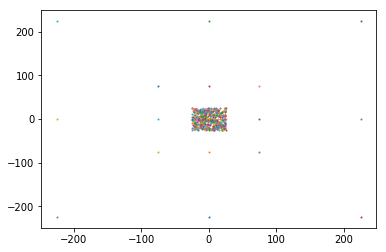

In [2]:
with open('obj/shrubs.obj') as O:
    for line in O:
        if 'clone' in line:
            plt.scatter(float(line.split()[1]), float(line.split()[2]), s=1)

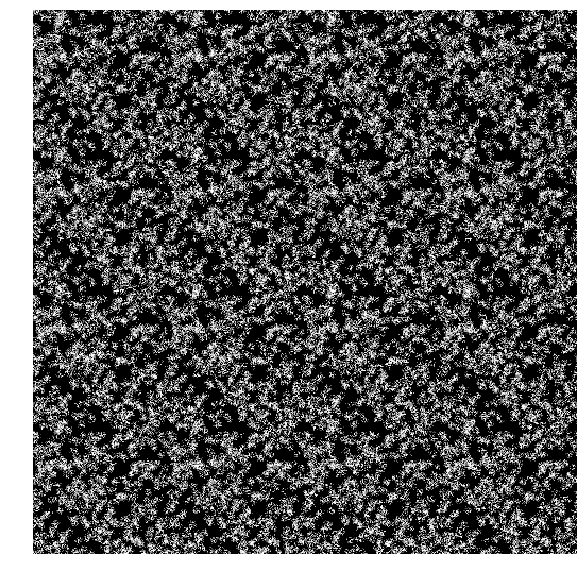

In [3]:
cmd = 'echo 16 0 0 200 100 100 512 512 1 output/shrubs.height.hips | \
       start obj/shrubs.obj'

error = run_start(cmd)

if not error:
    hips2img('output/shrubs.height.hips', order=[0])

In [4]:
MIN, MAX, MEAN, STD = hipstats('output/shrubs.height.hips')
print(MAX)

1.29593


/home/armstonj/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


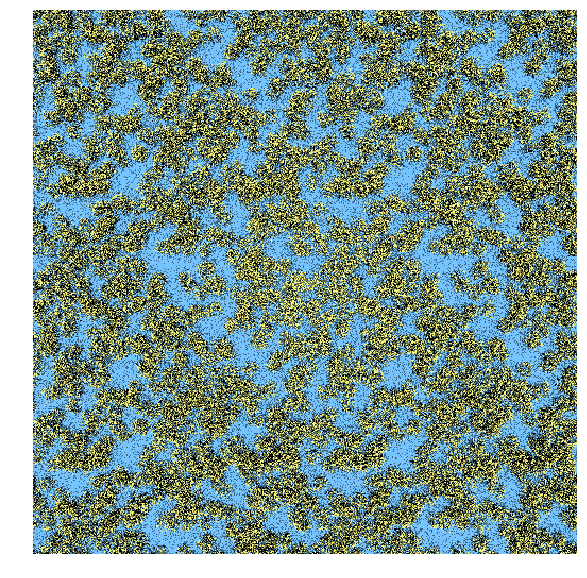

In [5]:
update_existing_camera('camera/simple.camera', 'camera/shrubs.camera', oname='output/shrubs',
                       new_options={'geometry.boomLength':50,
                                    'geometry.idealArea':50,
                                    'samplingCharacteristics.rpp':1})

cmd = 'echo 14 camera/shrubs.camera light/simple.light | \
       start -RATm 5 -RATsensor_wavebands wb/waveband.dat obj/shrubs.obj'
error = run_start(cmd)

if not error:
    hips2img('output/shrubs.hips')

/gpfs/data1/vclgp/armstonj/git/librat_in_jupyter/hips.py:59: RuntimeWarning: invalid value encountered in true_divide
  arr_b = ((arr_b - np.percentile(arr_b, 2.5)) / np.percentile(arr_b, 97.5))
/gpfs/data1/vclgp/armstonj/git/librat_in_jupyter/hips.py:60: RuntimeWarning: invalid value encountered in less
  arr_b[arr_b < 0] = 0
/gpfs/data1/vclgp/armstonj/git/librat_in_jupyter/hips.py:61: RuntimeWarning: invalid value encountered in greater
  arr_b[arr_b > 1] = 1
/gpfs/data1/vclgp/armstonj/git/librat_in_jupyter/hips.py:59: RuntimeWarning: divide by zero encountered in true_divide
  arr_b = ((arr_b - np.percentile(arr_b, 2.5)) / np.percentile(arr_b, 97.5))
/home/armstonj/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


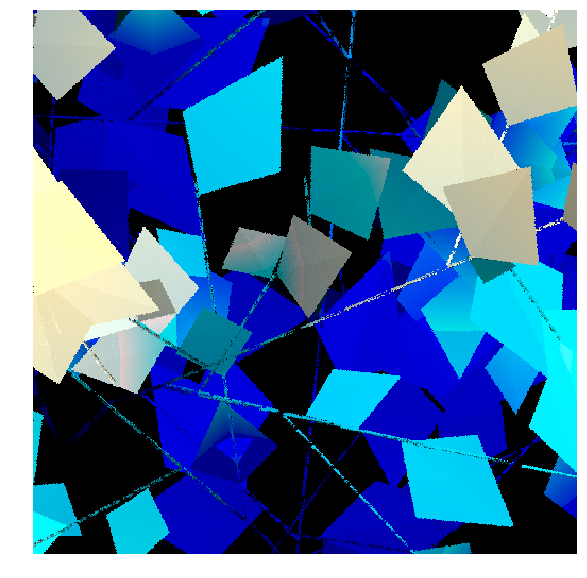

In [8]:
L = 1e-9 * 299792458 # speed of light m/ns
pl_ln = 4 * L # pulse length @ 4 ns
pl_sd = 1 # how much of a gaussian
boomLength = 10 # height of illumination (and camera)
footprint = .3

# update light file
update_existing_camera('light/pulse.lidar', 'light/shrubs.lidar',
                       new_options={'lidar.pulseStart':pl_ln/2.,
                                    'lidar.pulseSD':pl_sd,
                                    'lidar.pulseLength':pl_ln,
                                    'geometry.boomLength':boomLength,
                                    'geometry.idealArea':footprint},
                       remove=['lidar.pulseOPFile'])

oname='output/shrubs.lidar' # geometry.idealArea = footprint
binStep = .05
hoc = ((MAX // binStep) * binStep) + binStep # height of canopy
diff_camera_toc = boomLength - hoc
binStart = diff_camera_toc * 2.
nBins = np.ceil(((boomLength * 2.) - binStart) / binStep)

# update camera file
update_existing_camera('camera/pulse.lidar', 'camera/shrubs.lidar', oname=oname,
                       new_options={'geometry.idealArea':footprint,
                                    'geometry.boomLength':boomLength,
                                    'lidar.binStart':binStart,
                                    'lidar.binStep':binStep,
                                    'lidar.nBins':nBins})

# here we are using a dual wavelength LiDAR (wb/dual_waveband.dat)
cmd = 'echo 14 camera/shrubs.lidar light/shrubs.lidar | \
       start -RATm 5 -RATsensor_wavebands wb/waveband.dat obj/shrubs.obj'
error = run_start(cmd)

if not error:
    # the .hips file contains the slices from both the R and NIR,
    # if we do a read_header() on the .hips file we will notice
    # that there are 110 slices.  This means that the first 55 slices
    # are for the R band and the next 55 slices are for the NIR band.
    # The image below is therefore for the the NIR slices only.
    hips2img('{}.hips'.format(oname), order=[60, 80, 109])

In [9]:
from hips import read_header
print(nBins)
read_header('{}.hips'.format(oname))

53.0


(125, 220, 512, 512, 32)

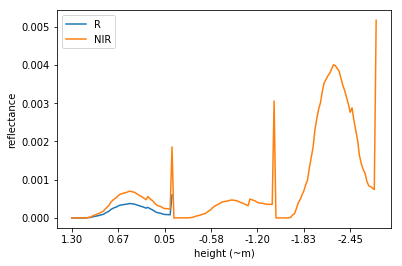

In [11]:
refl = np.loadtxt('output/shrubs.lidar.dat.direct')
ax = plt.subplot(111)
ax.plot(refl[:int(nBins+2), 1:].mean(axis=1), label='R')
ax.plot(refl[int(nBins+2):, 1:].mean(axis=1), label='NIR')
ax.set_xticklabels(['{:.2f}'.format(v) for v in MAX - (ax.get_xticks() * .05) / 2])
ax.set_xlabel('height (~m)')
ax.set_ylabel('reflectance')
ax.legend(loc='best')